In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# all constants
case = 1
sampling_time = 2
RAW_FEATURES_NAME_TO_NEW_NAME = {
    "Solar8000/ART_MBP": "mbp",
    "Solar8000/ART_SBP": "sbp",
    "Solar8000/ART_DBP": "dbp",
    "Solar8000/HR": "hr",
    "Solar8000/RR_CO2": "rr",
    "Solar8000/PLETH_SPO2": "spo2",
    "Solar8000/ETCO2": "etco2",
    "Orchestra/PPF20_CT": "pp_ct",
    "Primus/MAC": "mac",
}

min_mbp_segment = 40
threshold_peak = 30
window_size_peak = 500//sampling_time

segment_length = 20*60 // sampling_time
segment_shift = 30 // sampling_time
recovery_time = 0

min_time_ioh = 60 // sampling_time
min_value_ioh = 65

observation_window_length = 10*60 // sampling_time
max_mbp_segment = 150
leading_time = 2*60 // sampling_time

max_nan_segment = 0.2
signal_features_names = ['mbp', 'sbp', 'dbp', 'hr', 'rr', 'spo2', 'etco2', 'mac', 'pp_ct']


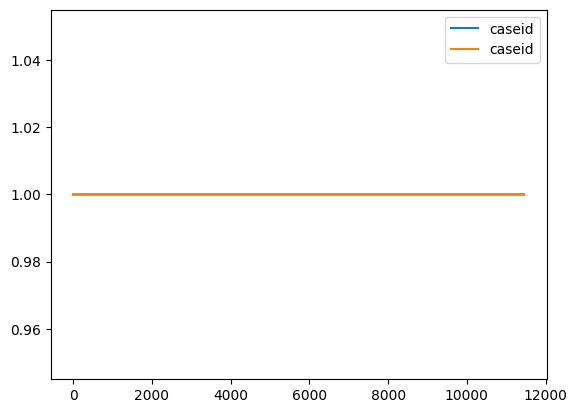

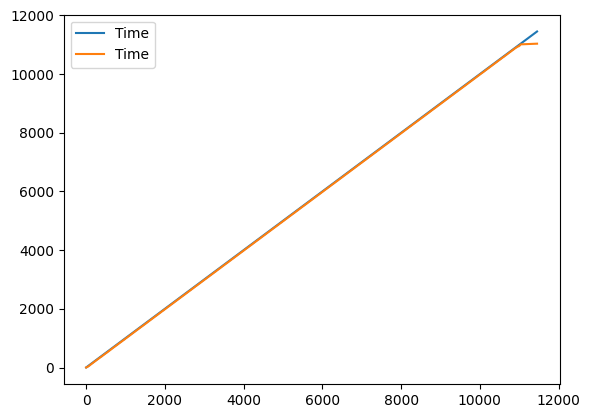

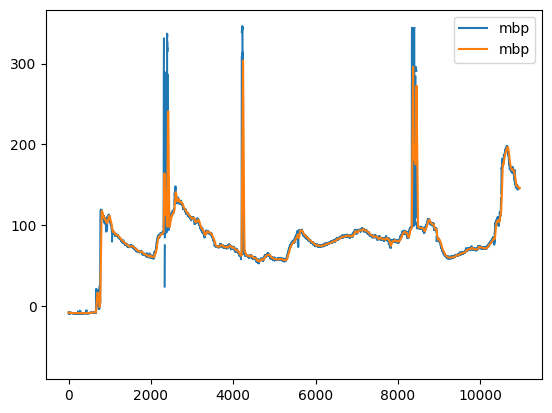

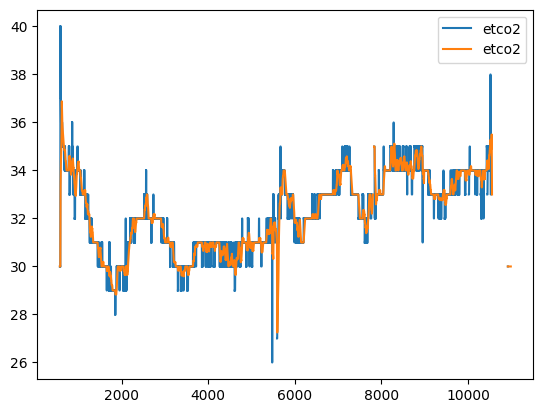

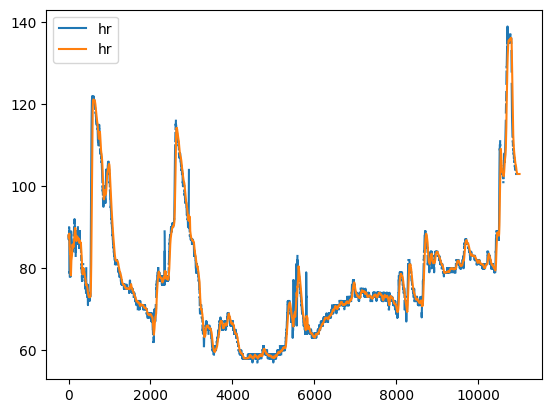

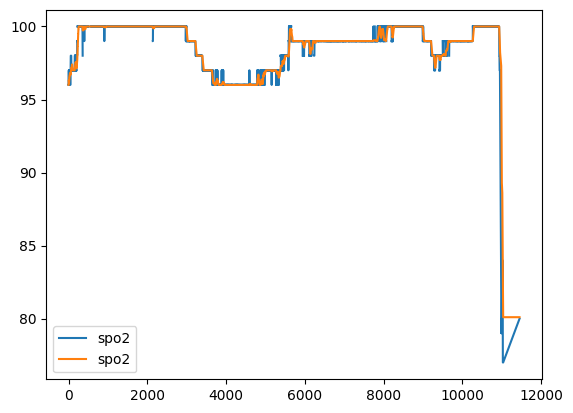

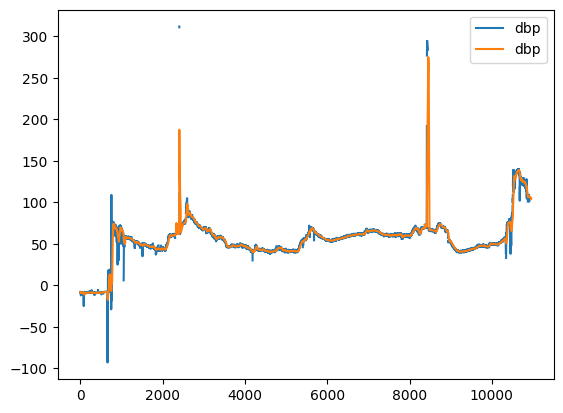

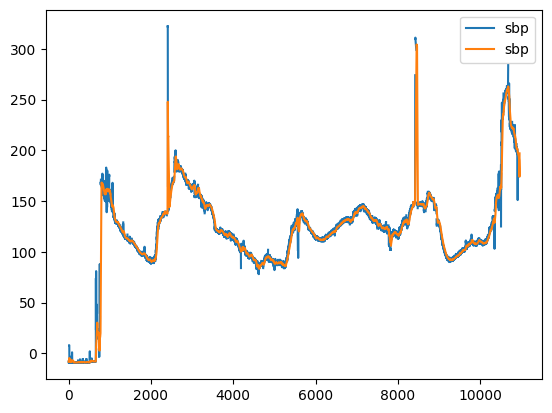

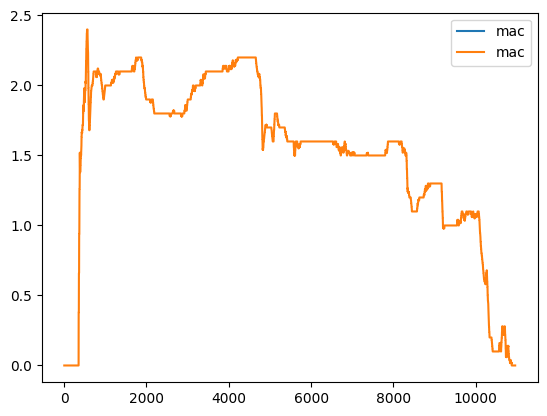

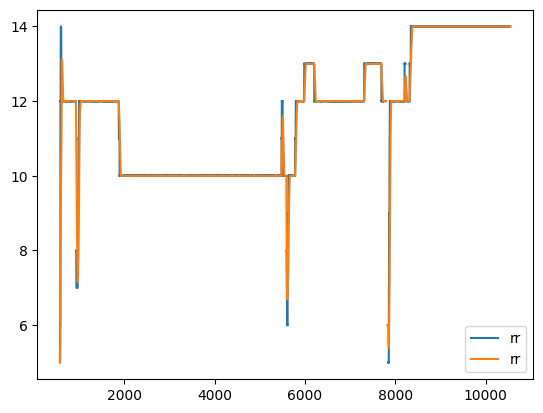

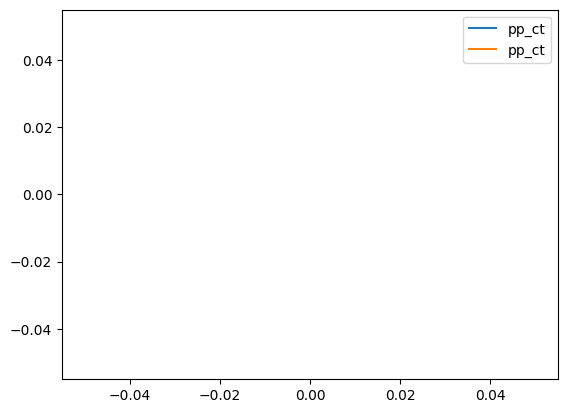

In [44]:

df = pd.read_parquet(f'data/cases/case-{case:04d}.parquet')


df = df.rename(columns=RAW_FEATURES_NAME_TO_NEW_NAME)

for col in df.columns:
    plt.plot(df['Time'], df[col], label=col)
    plt.plot(df['Time'], df[col].rolling(20, min_periods=1).mean(), label=col)
    plt.legend()
    plt.show()


df = df.rolling(20, min_periods=1).mean()




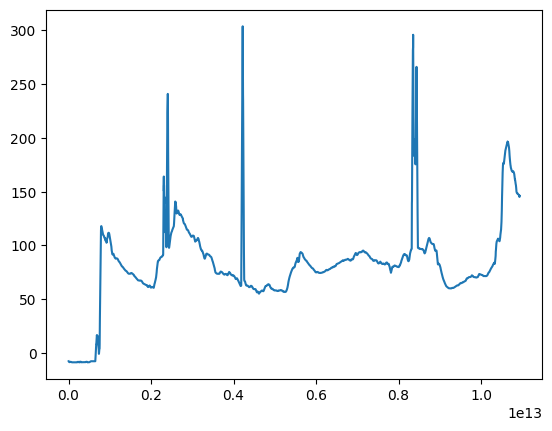

In [45]:
# resample
df['Time'] = df['Time'].astype('timedelta64[s]')
df = df.set_index('Time')
df_resample = df.resample(f"{sampling_time}S").last()

plt.plot(df_resample['mbp'])
plt.show()

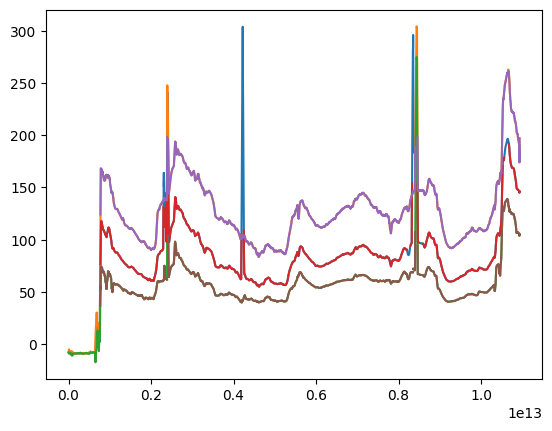

In [46]:
# preprocess peaks


plt.plot(df_resample['mbp'])
plt.plot(df_resample['sbp'])
plt.plot(df_resample['dbp'])

df_resample.mbp.mask(df_resample.mbp < min_mbp_segment, inplace=True)

# removing the nan values at the beginning and the ending
case_valid_mask = ~df_resample.mbp.isna()
case_data = df_resample[
    (np.cumsum(case_valid_mask) > 0)
    & (np.cumsum(case_valid_mask[::-1])[::-1] > 0)
].copy()

# remove peaks on the mean arterial pressure
rolling_mean_mbp = case_data.mbp.rolling(
    window=window_size_peak, center=True, min_periods=10
).mean()
rolling_mean_sbp = case_data.sbp.rolling(
    window=window_size_peak, center=True, min_periods=10
).mean()
rolling_mean_dbp = case_data.dbp.rolling(
    window=window_size_peak, center=True, min_periods=10
).mean()

# Identify peaks based on the difference from the rolling mean
case_data.mbp.mask(
    (case_data.mbp - rolling_mean_mbp).abs() > threshold_peak,
    inplace=True,
)
case_data.sbp.mask(
    (case_data.sbp - rolling_mean_sbp).abs() > threshold_peak * 1.5,
    inplace=True,
)
case_data.dbp.mask(
    (case_data.dbp - rolling_mean_dbp).abs() > threshold_peak,
    inplace=True,
)

plt.plot(case_data['mbp'])
plt.plot(case_data['sbp'])
plt.plot(case_data['dbp'])
plt.show()

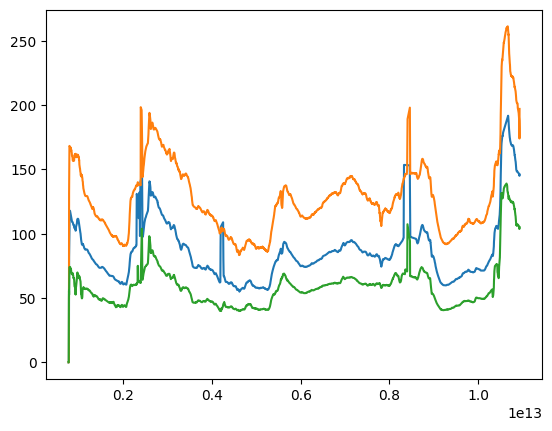

caseid    0
mbp       0
etco2     0
hr        0
spo2      0
dbp       0
sbp       0
mac       0
rr        0
pp_ct     0
dtype: int64


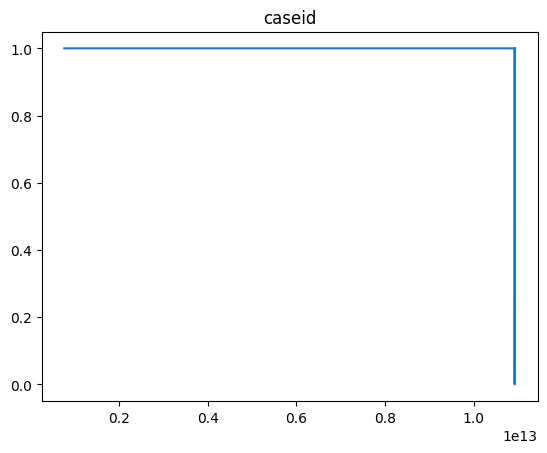

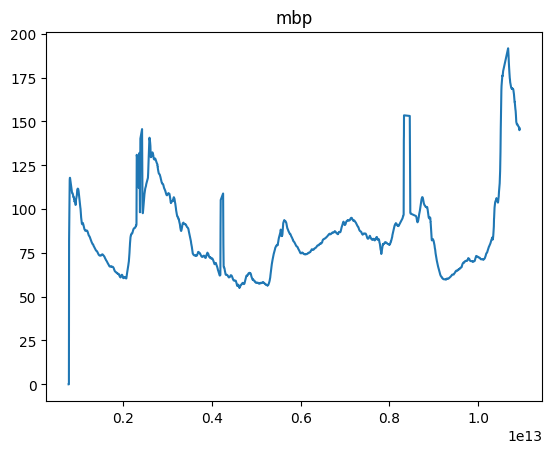

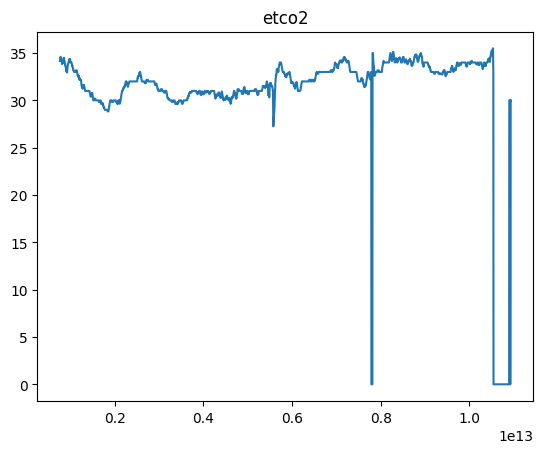

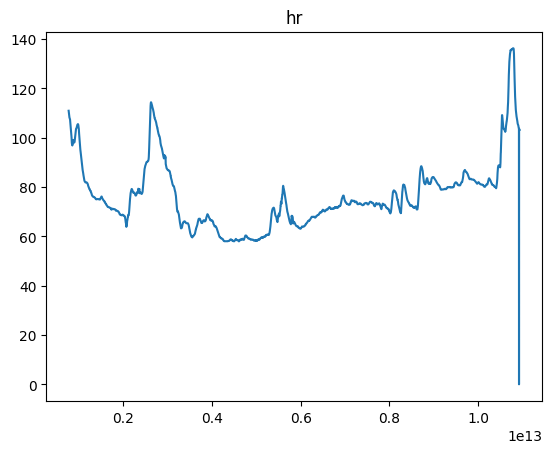

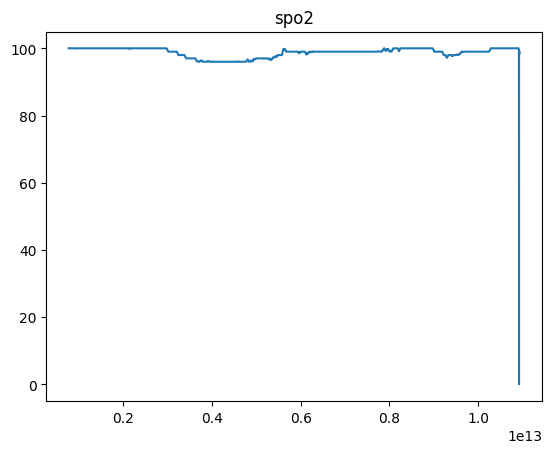

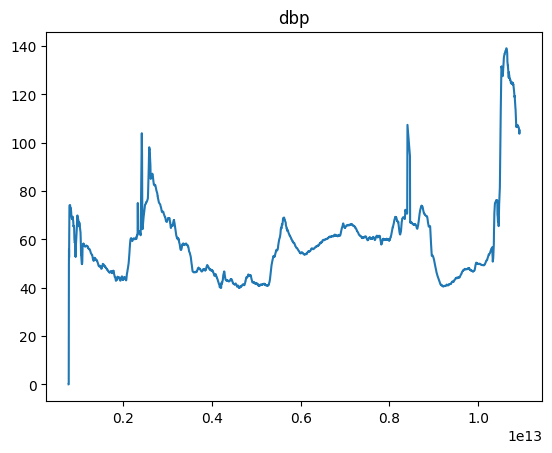

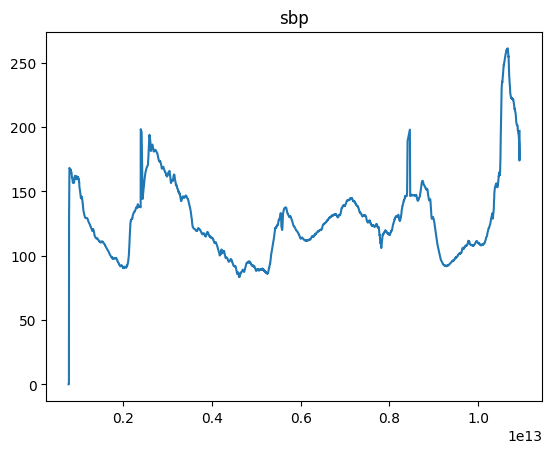

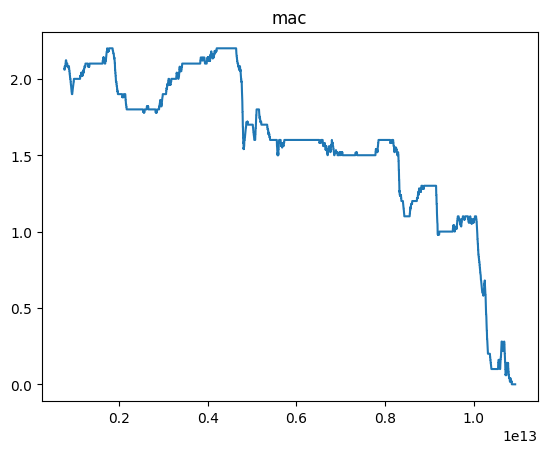

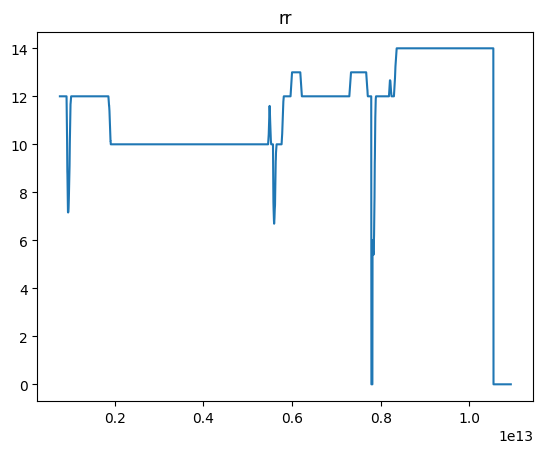

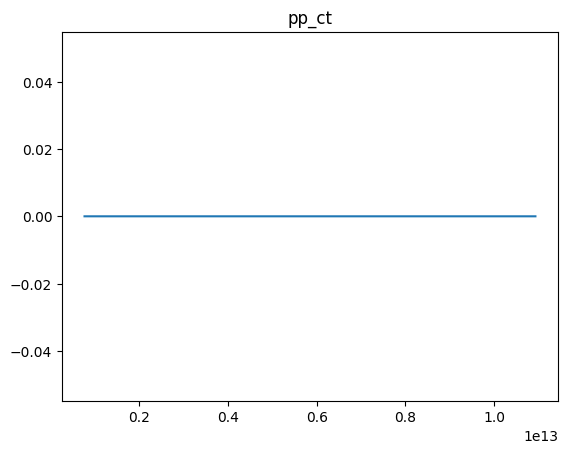

In [47]:
# fill the missing values
case_data['mbp'] = case_data['mbp'].interpolate()
case_data['sbp'] = case_data['sbp'].interpolate()
case_data['dbp'] = case_data['dbp'].interpolate()
case_data.fillna(value=0, inplace=True)


plt.plot(case_data['mbp'])
plt.plot(case_data['sbp'])
plt.plot(case_data['dbp'])
plt.show()

print(case_data.isna().sum())

for col in case_data.columns:
    plt.plot(case_data[col])
    plt.title(col)
    plt.show()

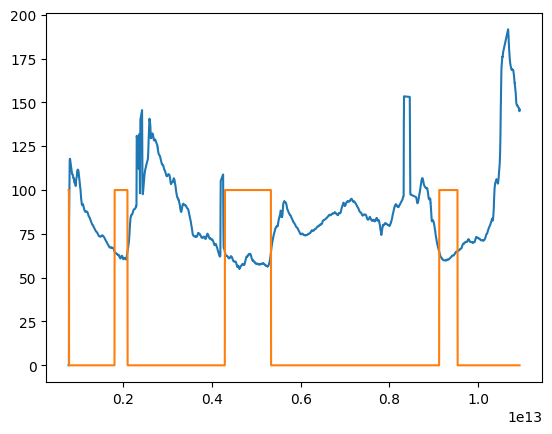

In [48]:
#labelling

def detect_ioh(window: pd.Series) -> bool:
    return (window < min_value_ioh).loc[~np.isnan(window)].all()

# create the label for the case
label_raw = (
    case_data.mbp.rolling(min_time_ioh, min_periods=1)
    .apply(detect_ioh)
    .fillna(0)
)

# Roll the window on the next self.min_time_ioh samples, see if there is a label
label = (
    label_raw.rolling(window=min_time_ioh, min_periods=1)
    .max()
    .shift(-min_time_ioh + 1, fill_value=0)
)

label_id = label.diff().clip(lower=0).cumsum().fillna(0)
label_id = label_id.astype(int)
label_id[label == 0] = np.nan

case_data['label'] = label
case_data['label_id'] = label_id

plt.plot(case_data['mbp'])
plt.plot(case_data['label']*100)
plt.show()

In [49]:
#segmentation



def validate_segment(segment, previous):
    mbp = segment[: observation_window_length].mbp
    if (mbp < min_mbp_segment).any() or (mbp > max_mbp_segment).any():
        return "bad mbp"

    # Any IOH detected in observation or leading window
    if segment.label[: (observation_window_length + leading_time)].any():
        return "IOH detected"

    # IOH in previous segment
    if previous_segment.label.sum() > 0:
        return "IOH in previous segment"

    for signal in signal_features_names:
        if signal in ["mac", "pp_ct"]:
            continue

        threshold_percent = max_nan_segment
        threshold_n_nans = threshold_percent * observation_window_length

        if (
            segment.iloc[: observation_window_length][signal].isnull().sum()
            > threshold_n_nans
        ):
            return "To many nan"
    
    return True





indexes_range = range(
    0, len(case_data) - segment_length, segment_shift
)
segment_id = 0
list_of_segments = []
for i_time_start in indexes_range:
    segment = case_data.iloc[i_time_start: i_time_start + segment_length]

    start_time_previous_segment = max(0, i_time_start - recovery_time)
    previous_segment = case_data.iloc[start_time_previous_segment:i_time_start]

    res = validate_segment(segment, previous_segment)
    if res is not True:
        print(f"Segment {segment_id} is invalid: {res}")
        continue
    segment_id += 1

print(f"Number total of segments: {len(indexes_range)}")
print(f"Number of valid segments: {segment_id}")

Segment 0 is invalid: bad mbp
Segment 10 is invalid: IOH detected
Segment 10 is invalid: IOH detected
Segment 10 is invalid: IOH detected
Segment 10 is invalid: IOH detected
Segment 10 is invalid: IOH detected
Segment 10 is invalid: IOH detected
Segment 10 is invalid: IOH detected
Segment 10 is invalid: IOH detected
Segment 10 is invalid: IOH detected
Segment 10 is invalid: IOH detected
Segment 10 is invalid: IOH detected
Segment 10 is invalid: IOH detected
Segment 10 is invalid: IOH detected
Segment 10 is invalid: IOH detected
Segment 10 is invalid: IOH detected
Segment 10 is invalid: IOH detected
Segment 10 is invalid: IOH detected
Segment 10 is invalid: IOH detected
Segment 10 is invalid: IOH detected
Segment 10 is invalid: IOH detected
Segment 10 is invalid: IOH detected
Segment 10 is invalid: IOH detected
Segment 10 is invalid: IOH detected
Segment 10 is invalid: IOH detected
Segment 10 is invalid: IOH detected
Segment 10 is invalid: IOH detected
Segment 10 is invalid: IOH detecte